In [24]:
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path("../..").absolute()))
from IPython.display import display, clear_output, Image
from three_stage_system_builder import ThreeStageSystemBuilder 
from environment import MultiStageEnv
from computation_sim.system import SystemDrawer
from computation_sim.nodes import ConstantNormalizer
from computation_sim.time import GammaDistributionSampler, GaussianTimeSampler, Clock, DurationSampler, as_age
from matplotlib import pyplot as plt
from typing import List, Tuple
import numpy as np

IMG_DIR = pathlib.Path("img")
IMG_DIR.mkdir(exist_ok=True)

In [25]:
DELTA_T = 10
# Set-up some default parameters
params = {
    "environment" : {
        "dt": DELTA_T, 
    },
    "draw_size": dict(width=1600, height=800),

}

In [26]:
def information_loss_reward(env: MultiStageEnv, action: np.ndarray) -> Tuple[float, dict]:
    last_received = env.output.last_received if env.output.last_received else None
    info = dict(
        lost_messages=sum(len(sink.received_messages) for sink in env.sinks),
        output_age_min=as_age(last_received.header.t_measure_youngest, env.clock.get_time()) if last_received else 0,
        output_age_max=as_age(last_received.header.t_measure_oldest, env.clock.get_time()) if last_received else 0,
        output_age_avg=as_age(last_received.header.t_measure_average, env.clock.get_time()) if last_received else 0,
    )
    # Punish message loss
    reward = - 1.0 * info["lost_messages"]
    # Encourage low age of oldest information
    reward -= 0.1 / 200.0 * float(info["output_age_max"])
    # Encourage low input
    reward -= 0.01 * np.sum(action)
    return reward, info

class EnvBuilder:
    def __init__(self, dt = 1):
        self.input_sampler = GaussianTimeSampler(0.0, 1.0, 5.0, 100.0)
        self.input_compute_sampler = GammaDistributionSampler(5.0, 1.0, 3.0, 30.0)
        self.edge_compute_sampler = GammaDistributionSampler(3.0, 1.0, 1.0, 30.0)
        self.global_compute_sampler = GammaDistributionSampler(9.0, 1.0, 3.0, 30.0)
        self.age_normalizer = ConstantNormalizer(1.0)
        self.count_normalizer = ConstantNormalizer(1.0)
        self.occupancy_normalizer = ConstantNormalizer(1.0)
        self.reward_function = information_loss_reward
        self.dt = dt
        self.cost_message_loss = 1.0
        self.cost_output_time = 0.001
        self.cost_input = 0.1

    def build(self) -> MultiStageEnv:
        clock = Clock(0)
        builder = ThreeStageSystemBuilder(clock, self.age_normalizer, self.count_normalizer, self.occupancy_normalizer)

        # Set-up the sensor chains
        s0 = [
            builder.add_sensor_chain("0", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("1", 0, 100, self.input_sampler, self.input_compute_sampler),
        ]
        s1 = [
            builder.add_sensor_chain("2", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("3", 0, 100, self.input_sampler, self.input_compute_sampler),
        ]

        # Set-up the edge nodes
        m = [
            builder.add_edge_compute("0", s0, self.edge_compute_sampler, 100.0),
            builder.add_edge_compute("1", s1, self.edge_compute_sampler, 100.0),
        ]

        # Set-up the output node
        builder.add_output_compute(m, self.global_compute_sampler, 100.0)
        builder.build()

        system = builder.system
        system.update()
        sinks = [
            builder._nodes["SENSOR_BUFFER_LOST"],
            builder._nodes["SENSOR_COMPUTE_LOST"],
            builder._nodes["SENSOR_COMPUTE_BUFFER_LOST"],
            builder._nodes["EDGE_COMPUTE_LOST"],
            builder._nodes["EDGE_COMPUTE_BUFFER_LOST"],
            builder._nodes["OUTPUT_COMPUTE_LOST"],
        ]
        output = builder.nodes["OUTPUT"]
        return MultiStageEnv(clock, system, sinks, output, self.reward_function, self.dt)

def plot_sampler(sampler: DurationSampler, n: int = 100000) -> Tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(1, 1)
    samples = [sampler.sample() for i in range(n)]
    ax.hist(samples)
    return fig, ax



In [30]:
# Build the environment
builder = EnvBuilder(**params["environment"])
env = builder.build()

# Visualize the system graph
drawer = SystemDrawer()
drawer.build(env.system.node_graph)
drawer.fw.update_layout(**params["draw_size"])

# Create a png in case page is statically rendered (github)
drawer.fw.write_image(str(IMG_DIR / "three_stage_system.png"), **params["draw_size"])

# Display the system interactively
clear_output(wait=True)
display(drawer.fw)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 1.0},
              'mode': 'lines',
              'showlegend': False,
              'type': 'scatter',
              'uid': '260b56f5-e1a8-43ef-97d0-3380b71268b3',
              'x': [-0.7192982456140352, -0.4736842105263158, None,
                    -0.4736842105263158, -0.2280701754385965, None,
                    -0.4736842105263158, -0.2280701754385965, None,
                    -0.2280701754385965, 0.0175438596491228, None,
                    -0.2280701754385965, 0.0175438596491228, None,
                    0.0175438596491228, 0.2631578947368421, None,
                    0.0175438596491228, 0.2631578947368421, None,
                    0.2631578947368421, 0.5087719298245613, None,
                    0.2631578947368421, 0.5087719298245613, None,
                    -0.7192982456140352, -0.4736842105263158, None,
                    -0.4736842105263158, -0.2280701754385965, Non

Text(0.5, 1.0, 'Global Compute Sampler')

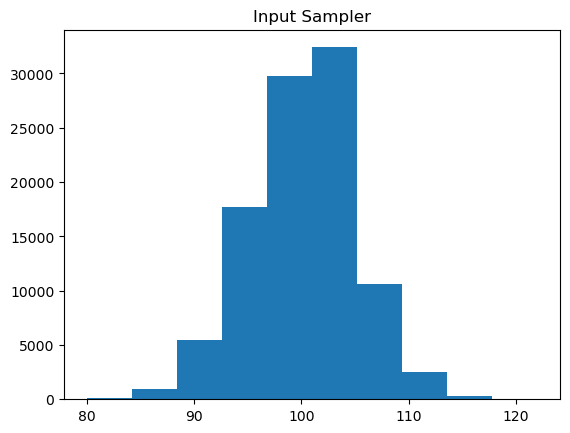

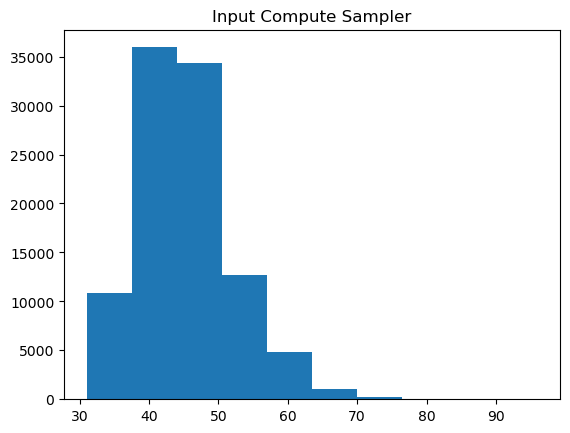

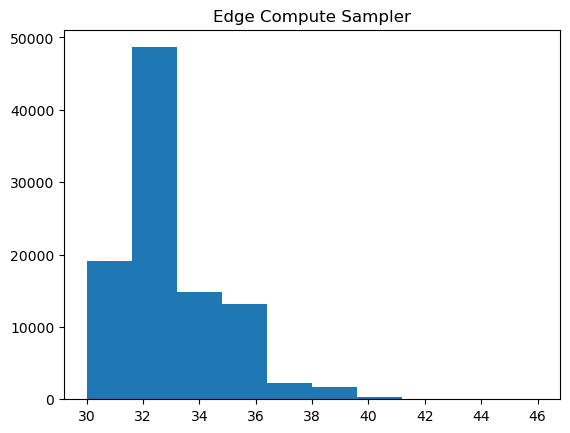

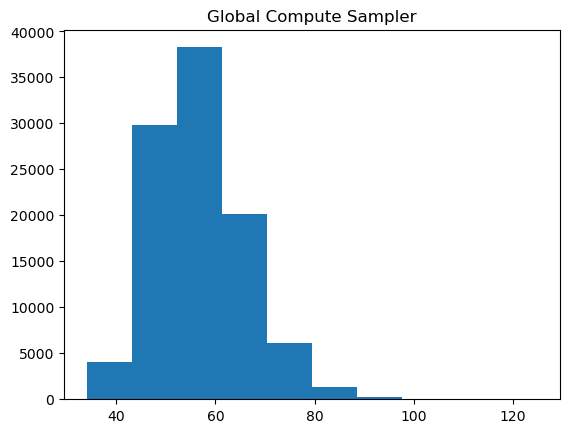

In [28]:
# Plot histograms of the execution time distributions
fig, ax = plot_sampler(builder.input_sampler)
ax.set_title('Input Sampler')
fig, ax = plot_sampler(builder.input_compute_sampler)
ax.set_title('Input Compute Sampler')
fig, ax = plot_sampler(builder.edge_compute_sampler)
ax.set_title('Edge Compute Sampler')
fig, ax = plot_sampler(builder.global_compute_sampler)
ax.set_title('Global Compute Sampler')